导入PyTorch包，对poisson方程使用PINN求解

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
#import mpl_toolkits.mplot3d as Axrs3D
import numpy as np

In [23]:
import numpy as np
from typing import Tuple

def generate_rectangle_points(
    x_range: Tuple[float, float],
    y_range: Tuple[float, float],
    x_num: int,
    y_num: int
) -> dict:
    """
    生成矩形区域的边界点、内部点及法向量
    
    参数：
        x_range : (x_min, x_max) x轴范围
        y_range : (y_min, y_max) y轴范围
        x_num   : x方向总点数（包含边界）
        y_num   : y方向总点数（包含边界）

    返回值：
        dict: 包含各类型采样点及法向量的字典，键包括：
            - boundary_points : 所有边界点坐标
            - interior_points : 内部点坐标
            - normals         : 所有点的法向量（内部点法向量为0）
            - left_points     : 左边界点
            - right_points    : 右边界点
            - bottom_points   : 下边界点
            - top_points      : 上边界点
    """
    # 生成网格基础坐标
    x_coords = np.linspace(x_range[0], x_range[1], x_num)
    y_coords = np.linspace(y_range[0], y_range[1], y_num)

    # ====================== 边界点生成 ======================
    # 左边界（排除端点）
    left_points = np.column_stack([
        np.full(y_num-2, x_range[0]),  # x坐标
        y_coords[1:-1]                 # y坐标（去端点）
    ])
    
    # 右边界（排除端点）
    right_points = np.column_stack([
        np.full(y_num-2, x_range[1]),
        y_coords[1:-1]
    ])
    
    # 下边界（排除端点）
    bottom_points = np.column_stack([
        x_coords[1:-1],
        np.full(x_num-2, y_range[0])
    ])
    
    # 上边界（排除端点）
    top_points = np.column_stack([
        x_coords[1:-1],
        np.full(x_num-2, y_range[1])
    ])

    # 合并所有边界点
    all_boundary = np.vstack([left_points, right_points, bottom_points, top_points])

    # ====================== 法向量生成 ======================
    # 左边界法向量 (-1, 0)
    left_normals = np.tile([-1, 0], (len(left_points), 1))
    
    # 右边界法向量 (1, 0)
    right_normals = np.tile([1, 0], (len(right_points), 1))
    
    # 下边界法向量 (0, -1)
    bottom_normals = np.tile([0, -1], (len(bottom_points), 1))
    
    # 上边界法向量 (0, 1)
    top_normals = np.tile([0, 1], (len(top_points), 1))

    # 合并法向量
    boundary_normals = np.vstack([left_normals, right_normals, bottom_normals, top_normals])

    # ====================== 内部点生成 ======================
    # 生成内部网格点（排除边界）
    x_internal, y_internal = np.meshgrid(x_coords[1:-1], y_coords[1:-1])
    interior_points = np.column_stack([x_internal.ravel(), y_internal.ravel()])

    # ====================== 组合所有点 ======================
    total_points = np.vstack([all_boundary, interior_points])
    
    # 创建法向量数组（内部点法向量设为0）
    total_normals = np.zeros((len(total_points), 2))
    total_normals[:len(all_boundary)] = boundary_normals

    return {
        "boundary_points": all_boundary,
        "interior_points": interior_points,
        "normals": boundary_normals,
        "left_points": left_points,
        "right_points": right_points,
        "bottom_points": bottom_points,
        "top_points": top_points
    }

In [24]:
# 生成采样点
domain_data= generate_rectangle_points(
    x_range=(0, 1),
    y_range=(0, 1),
    x_num=70,
    y_num=70
)

# 查看输出结构
print(f"边界点数量: {len(domain_data['boundary_points'])}")  # 输出：12
print(f"内部点数量: {len(domain_data['interior_points'])}")  # 输出：9
print(f"总点数: {len(domain_data['boundary_points']) + len(domain_data['interior_points'])}")  # 输出：21

# 获取左边界点及对应法向量
left_points = domain_data['left_points']
left_normals = domain_data['normals'][:len(left_points)]

边界点数量: 272
内部点数量: 4624
总点数: 4896


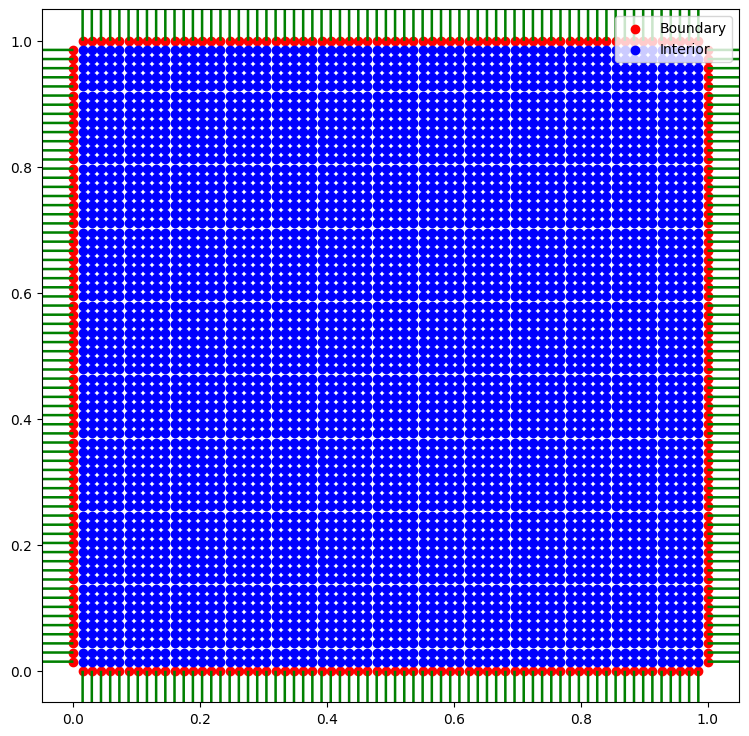

In [25]:
# 绘制采样点
plt.figure(figsize=(9, 9))
plt.scatter(domain_data['boundary_points'][:,0], domain_data['boundary_points'][:,1], 
           c='r', label='Boundary')
plt.scatter(domain_data['interior_points'][:,0], domain_data['interior_points'][:,1],
           c='b', label='Interior')
plt.quiver(domain_data['boundary_points'][:,0], domain_data['boundary_points'][:,1],
          domain_data['normals'][:len(domain_data['boundary_points']),0],
          domain_data['normals'][:len(domain_data['boundary_points']),1],
          color='g', scale=15)
plt.legend()
plt.show()

In [26]:
# 转换为 PyTorch 张量（自动处理 float32 类型）
def numpy_to_tensor(data_dict):
    return {
        key: torch.from_numpy(value).float() if isinstance(value, np.ndarray) else value
        for key, value in data_dict.items()
    }

torch_data = numpy_to_tensor(domain_data)

In [27]:
def compute_f(x):
    """
    计算 PDE 右端项 f(x)
    假设 f(x, y) = sin(πx) * sin(πy)
    """
    return 2* np.pi**2 * torch.sin(np.pi * x[:, 0]) * torch.sin(np.pi * x[:, 1])

def compute_dirichlet_bc(x):
    """
    计算 Dirichlet 边界条件标签
    假设 u(x, y) = sin(πx) * sin(πy) 在边界上
    """
    return torch.sin(np.pi * x[:, 0]) * torch.sin(np.pi * x[:, 1])

def compute_neumann_bc(x, normals):
    """
    计算 Neumann 边界条件标签
    假设 u(x, y) = sin(πx) * sin(πy)，则法向导数为：
    ∂u/∂n = π * cos(πx) * sin(πy) * n_x + π * sin(πx) * cos(πy) * n_y
    """
    # 计算 ∂u/∂x 和 ∂u/∂y
    du_dx = np.pi * torch.cos(np.pi * x[:, 0]) * torch.sin(np.pi * x[:, 1])
    du_dy = np.pi * torch.sin(np.pi * x[:, 0]) * torch.cos(np.pi * x[:, 1])
    
    # 计算法向导数 ∂u/∂n = ∂u/∂x * n_x + ∂u/∂y * n_y
    normal_derivative = du_dx * normals[:, 0] + du_dy * normals[:, 1]
    
    return normal_derivative

def compute_bc(x, normals, boundary_type="dirichlet"):
    """
    计算边界条件标签
    参数：
        x : 边界点坐标
        normals : 边界法向量
        boundary_type : 边界类型（"dirichlet" 或 "neumann"）
    """
    if boundary_type == "dirichlet":
        return compute_dirichlet_bc(x)
    elif boundary_type == "neumann":
        return compute_neumann_bc(x, normals)
    else:
        raise ValueError("Unknown boundary type")
    
def compute_bc_by_segment(x, normals,segment=["dirichlet", "dirichlet", "dirichlet", "neumann"]):
    """
    0:neuman
    1:dirichlet
    
    根据边界分段计算标签
    假设：
        - 左边界 (x=0): Dirichlet
        - 右边界 (x=1): Neumann
        - 下边界 (y=0): Dirichlet
        - 上边界 (y=1): Neumann
    """
    labels = torch.zeros(len(x))
    
    # 左边界 (x=0)
    left_mask = x[:, 0] == 0
    #labels[left_mask] = compute_dirichlet_bc(x[left_mask])
    
    # 右边界 (x=1)
    right_mask = x[:, 0] == 1
    #labels[right_mask] = compute_neumann_bc(x[right_mask], normals[right_mask])
    
    # 下边界 (y=0)
    bottom_mask = x[:, 1] == 0
    labels[bottom_mask] = compute_dirichlet_bc(x[bottom_mask])
    
    # 上边界 (y=1)
    top_mask = x[:, 1] == 1
    #labels[top_mask] = compute_neumann_bc(x[top_mask], normals[top_mask])
    mask = [left_mask, right_mask, bottom_mask, top_mask]
    
    for msk, seg in zip(mask, segment):
        print(len(msk), len(normals), len(normals[msk]))
        labels[msk] = compute_bc(x[msk], normals[msk] ,boundary_type=seg) 
    return labels

In [28]:
# 定义特征-标签组合
# 假设 y 为 PDE 右端项或边界条件值
interior_features = torch_data["interior_points"]
interior_labels = compute_f(interior_features)  # 计算 PDE 右端项 f(x,y)
# 左右下上边界 选择： "neumann"  "dirichlet"
segment=["dirichlet", "dirichlet", "dirichlet", "neumann"]
boundary_features = torch_data["boundary_points"]
normals = torch_data['normals']

boundary_labels = compute_bc_by_segment(boundary_features, normals,segment=segment) # 计算边界条件值


272 272 68
272 272 68
272 272 68
272 272 68


In [29]:
# 参数初始化
def init_weights(m):
    if isinstance(m, nn.Linear):  # 对线性层进行初始化
        torch.nn.init.xavier_uniform_(m.weight)  # Xavier初始化
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)  # 偏置初始化为0
    elif isinstance(m, nn.Conv2d):  # 对卷积层进行初始化（如果有的话）
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')  # He初始化
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)  # 偏置初始化为0

In [30]:


class PINN(nn.Module):
    '''PINN神经网络'''
    def __init__(self, in_features=2, out_features=1, hidden_layers=8, neurons=50, activation='tanh'):
        super(PINN, self).__init__()
        
        if activation == 'tanh':
            act_fn = nn.Tanh()
        elif activation == 'relu':
            act_fn = nn.ReLU()
        elif activation == 'sine':
            # 自定义 sine 激活
            act_fn = lambda: torch.sin
        else:
            raise ValueError("Unsupported activation")
        
        layers = []
        layers.append(nn.Linear(in_features, neurons))
        layers.append(act_fn)
        
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons, neurons))
            layers.append(act_fn)
        
        layers.append(nn.Linear(neurons, out_features))
        
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)


In [31]:
# 模型结构
net = PINN(hidden_layers=4)
print(net)

PINN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Tanh()
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Tanh()
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [32]:

def BC_loss(u_preds, labels, x, normals, segment=["dirichlet", "dirichlet", "dirichlet", "neumann"]):
    """
    计算混合边界条件损失
    参数：
        u_preds : 模型预测的边界值 (Tensor)
        labels  : 边界条件真实值 (Tensor)
        x       : 边界点坐标 (Tensor)
        normals : 边界法向量 (Tensor)
        segment : 各边界的类型列表，顺序为 [左, 右, 下, 上]
    """
    # 生成边界掩码
    left_mask = x[:, 0] == 0
    right_mask = x[:, 0] == 1
    bottom_mask = x[:, 1] == 0
    top_mask = x[:, 1] == 1

    mask = [left_mask, right_mask, bottom_mask, top_mask]
    dir = []
    neu = []
    
    # 遍历各边界
    for msk, seg in zip(mask, segment):
        if not msk.any():
            continue  # 跳过无点的边界
            
        u_pred = u_preds[msk]
        #x_bc = x[msk]
        x_bc = torch.index_select(x, dim=0, index=torch.nonzero(msk).squeeze())
        normal_vectors = normals
        #g_true = labels[msk]
        g_true = torch.index_select(labels, dim=0, index=torch.nonzero(msk).squeeze())

        grad_u = torch.autograd.grad(
                u_preds, x,
                grad_outputs=torch.ones_like(u_preds),
                create_graph=True)[0]
        if seg == "dirichlet":
            # Dirichlet 条件损失
            dir.append(torch.mean((u_pred - g_true)**2))
        else:
            # Neumann 条件损失
           
            normal_deriv = torch.sum(grad_u[msk] * normal_vectors[msk], dim=1)
            neu.append(torch.mean((normal_deriv - g_true)**2))

    # 计算总损失
    loss_dir = sum(dir) if dir else torch.tensor(0.0)
    loss_neu = sum(neu) if neu else torch.tensor(0.0)
    
    return loss_dir, loss_neu


def PDE_loss(y_hat, x, y):
    # 计算二维拉普拉斯算子的正确方法
    # x = x.requires_grad_(True)
    ux = torch.autograd.grad(y_hat, x, grad_outputs=torch.ones_like(y_hat), 
                            create_graph=True, retain_graph=True, allow_unused=True)[0]
    ux_x = torch.autograd.grad(ux[:,0], x, grad_outputs=torch.ones_like(ux[:,0]), 
                            create_graph=True)[0][:,0]  # u_xx
    uy_y = torch.autograd.grad(ux[:,1], x, grad_outputs=torch.ones_like(ux[:,1]), 
                            create_graph=True)[0][:,1]   # u_yy
    Laplace_u = ux_x + uy_y
    pde_residual = Laplace_u + y  # 假设PDE为 Δu + y = 0
    return torch.mean(pde_residual**2) # MSE作为损失

In [ ]:
def train_full_batch(model, interior_features, boundary_features, 
                     interior_labels, boundary_labels, optimizer):
    
    # 计算模型对内部点的预测
    u_interior = model(interior_features)
    # 计算模型对边界点的预测
    u_boundary = model(boundary_features)

    # 计算 PDE 损失
    loss_pde = PDE_loss(u_interior, interior_features, interior_labels)
    
    # 计算边界条件损失
    loss_dir, loss_neu = BC_loss(u_boundary, boundary_labels, boundary_features, normals, segment)
    
    # 计算总损失，结合 PDE 损失和边界条件损失
    total_loss = loss_pde + loss_dir + loss_neu

    # 清空梯度
    optimizer.zero_grad()
    # 反向传播，计算梯度
    total_loss.backward()
    # 更新模型参数
    optimizer.step()

    return loss_pde, loss_dir, loss_neu


In [50]:
def train(model, optimizer, interior_features, interior_labels, 
      boundary_features, boundary_labels,device):
    model.apply(init_weights)
    
    model.to(device)
    interior_features.to(device)
    boundary_features.to(device)
    interior_labels.to(device)
    boundary_labels.to(device)

    boundary_features.requires_grad_(True)
    interior_features.requires_grad_(True)

    
    for epoch in range(1000):
        l_pde, l_dir, l_neu= train_full_batch(model, interior_features, boundary_features, optimizer)

        if (epoch+1) % 50 == 0:
            print(f'epoch: {epoch+1}   pde loss: {l_pde:5f}   dirichlet loss: {l_dir:5f}  neumann loss: {l_neu:5f}')

In [48]:
def try_gpu(i=0):
    """如果存在，则返回gpu(i)，否则返回cpu()

    Defined in :numref:`sec_use_gpu`"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [49]:
# 将数据移至 GPU（如果可用）
device = try_gpu()

model = PINN(hidden_layers=3,neurons=30)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, interior_features, interior_labels, 
      boundary_features, boundary_labels,device)

pde loss: 24.393074   dirichlet loss 9.570461  neumann 3.683589
pde loss: 7.881536   dirichlet loss 3.137182  neumann 0.744169
pde loss: 4.723773   dirichlet loss 1.581986  neumann 0.507926
pde loss: 1.680549   dirichlet loss 0.401939  neumann 0.419977
pde loss: 0.754917   dirichlet loss 0.097963  neumann 0.371759
pde loss: 0.486767   dirichlet loss 0.084959  neumann 0.299978
pde loss: 0.346965   dirichlet loss 0.067134  neumann 0.261875
pde loss: 0.248026   dirichlet loss 0.053982  neumann 0.234295
pde loss: 0.174443   dirichlet loss 0.045393  neumann 0.204286
pde loss: 0.125994   dirichlet loss 0.039573  neumann 0.173838
pde loss: 0.095019   dirichlet loss 0.035342  neumann 0.144886
pde loss: 0.076642   dirichlet loss 0.032656  neumann 0.119627
pde loss: 0.066310   dirichlet loss 0.031393  neumann 0.098208
pde loss: 0.059793   dirichlet loss 0.031020  neumann 0.079732
pde loss: 0.055018   dirichlet loss 0.030999  neumann 0.063584
pde loss: 0.051149   dirichlet loss 0.030975  neumann 

In [ ]:
def plot_solution(model):
    x = torch.linspace(0, 1, 100).reshape(-1, 1)
    y = torch.linspace(0, 1, 100).reshape(-1, 1)
    X, Y = torch.meshgrid(x.squeeze(), y.squeeze())
    X = X.flatten().reshape(-1, 1)
    Y = Y.flatten().reshape(-1, 1)
    XY = torch.cat((X, Y), dim=1)
    u_pred = model(XY).detach().numpy()  # 转换为numpy数组
    U = u_pred.reshape(100, 100)

    
    x1 = np.linspace(0, 1, 100).reshape(-1, 1)
    y1 = np.linspace(0, 1, 100).reshape(-1, 1)
    X1, Y1 = np.meshgrid(x1, y1)
    u_exact = np.sin(np.pi*X1)*np.sin(np.pi*Y1)
    
    # u_exact1 = np.sin(np.pi*x1)*np.sin(np.pi*y1)
    # 计算相对误差
    relative_error = np.abs(U - u_exact) 
    
    # 输出相对误差的最大值和均值
    print(f"Maximum Absolute Error: {np.max(relative_error)}")
    print(f"Mean Absolute Error: {np.mean(relative_error)}")

    # 可视化相对误差
    plt.figure(figsize=(6, 5))
    plt.contourf(X1, Y1, relative_error, 50, cmap='jet')
    plt.colorbar()
    plt.title("Absolute Error Contour Plot")
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    plt.show()


    plt.figure(figsize=(6, 5))
    plt.contourf(X.reshape(100, 100).numpy(), Y.reshape(100, 100).numpy(), U, 50, cmap='jet')
    plt.colorbar()
    plt.title("Solution of Poisson Equation (PINN)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

    plt.figure(figsize=(6, 5))

    # 绘制平面图
    plt.contourf(X1, Y1, u_exact, 50, cmap='jet')  # contourf画填充的等高线图

    # 添加颜色条
    plt.colorbar()

    # 添加标题和轴标签
    plt.title("Contour Plot of u_exact = sin(pi*x) * sin(pi*y)")
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")

    # 显示图形
    plt.show()

/home/austin/.conda/envs/d2l/lib/python3.9/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Maximum Absolute Error: 0.716531496727939
Mean Absolute Error: 0.2569691726245639


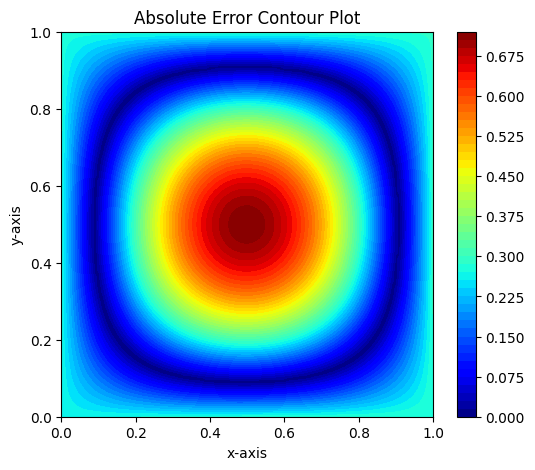

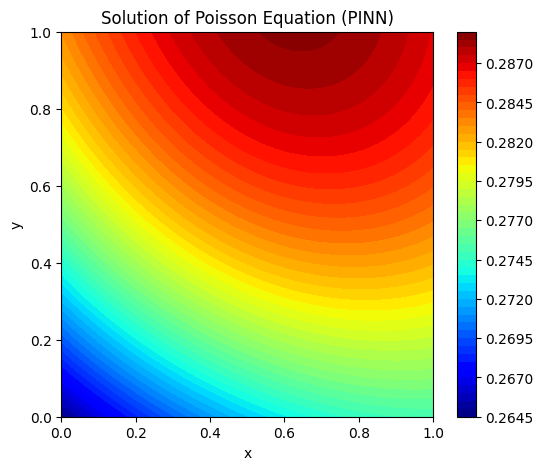

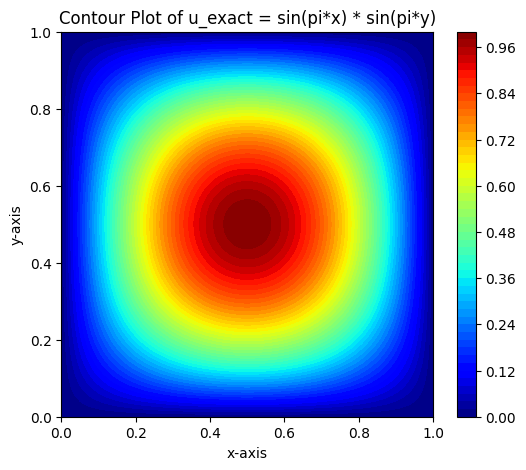

In [ ]:
plot_solution(net)